# Run Analysis

1. [Introduction](#1-introduction)
2. [Preparation](#2-preparation)  
    2.1. [Dependencies](#21-dependencies)  
    2.2. [Load Data](#22-load-data)
3. [Analysis](#3-analysis)  
   3.1. [Filter Performance](#31-filter-performance)
4. [Visualization](#4-visualization)

## 1. Introduction

## 2. Preparation

### 2.1. Dependencies

In [1]:
import os
import csv
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def extract_records(filepath):
    headers = []
    records = []
    with open(filepath, newline='') as file:
        reader = csv.reader(file, delimiter='\t')
        headers = next(reader)
        records.extend([record for record in reader])
    return headers, len(records), dict(zip(np.transpose(headers), np.transpose(records)))

In [3]:
def lineplot(n_samples, ymin, ymax, lines, xlabel, ylabel, title, markers=[], labels=[], n_yticks=5):
    t = np.arange(n_samples)
    plt.figure(figsize=(12, 3))
    for i, line in enumerate(lines):
        plt.plot(t, line, label=labels[i] if labels else '')
    if markers is not None: 
        plt.plot(markers, [np.mean([ymin, ymax])] * len(markers), 'or', alpha=0.4, label=labels[-1] if labels else '')
    plt.yticks(np.linspace(ymin, ymax, n_yticks))
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    if labels: plt.legend()
    plt.show()

In [4]:
def boxplot(boxes, labels, title, notch=True, ylabel=''):
    plt.figure()
    plt.boxplot(boxes, tick_labels=labels, notch=notch, widths=[0.25] * boxes.shape[1])
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid()
    plt.show()

### 2.2. Load Data

In [5]:
DIR = '../_artifacts/20250512-052211_accumulated_cloud'
TAB = os.path.join(DIR, '20250512-052211_accumulated_cloud_tfoutlier.tab')
PCL = os.path.join(DIR, '20250512-052329_accumulated_cloud_35mm_38550pts.pcd')

print(DIR, TAB, PCL, sep='\n')

../_artifacts/20250512-052211_accumulated_cloud
../_artifacts/20250512-052211_accumulated_cloud/20250512-052211_accumulated_cloud_tfoutlier.tab
../_artifacts/20250512-052211_accumulated_cloud/20250512-052329_accumulated_cloud_35mm_38550pts.pcd


In [6]:
HEADERS, N_RECORDS, columns = extract_records(TAB)

print(HEADERS)
print('Number of headers:', len(HEADERS), '| Number of samples:', N_RECORDS)

['timestamp', 'elapsed', 'tx', 'ty', 'tz', 'rx', 'ry', 'rz', 'outlier', 'max_translation_m', 'max_rotation_m', 'history_size']
Number of headers: 12 | Number of samples: 74


In [7]:
TAB_TFOUTLIER                                       = TAB
TAB_NAN                                             = os.path.join(DIR, '20250512-052211_accumulated_cloud_nan.tab')
TAB_SPATIAL                                         = os.path.join(DIR, '20250512-052211_accumulated_cloud_spatial.tab')
TAB_SOR                                             = os.path.join(DIR, '20250512-052211_accumulated_cloud_sor.tab')

NAN_HEADERS, NAN_N_RECORDS, NAN_COLS                = extract_records(TAB_NAN)
SPATIAL_HEADERS, SPATIAL_N_RECORDS, SPATIAL_COLS    = extract_records(TAB_SPATIAL)
SOR_HEADERS, SOR_N_RECORDS, SOR_COLS                = extract_records(TAB_SOR)

tfoutlier                                           = {'headers': HEADERS, 'len': N_RECORDS, 'data': columns}
nan                                                 = {'headers': NAN_HEADERS, 'len': NAN_N_RECORDS, 'data': NAN_COLS}
spatial                                             = {'headers': SPATIAL_HEADERS, 'len': SPATIAL_N_RECORDS, 'data': SPATIAL_COLS}
sor                                                 = {'headers': SOR_HEADERS, 'len': SOR_N_RECORDS, 'data': SOR_COLS}

In [8]:
ALL_N_RECORDS = np.array([tfoutlier['len'], nan['len'], spatial['len'], sor['len']])
MIN_N_RECORDS = ALL_N_RECORDS.min()

print('Nº of records per filter -->', 'tfoulier:', ALL_N_RECORDS[0], 'nan:', ALL_N_RECORDS[1], 'spatial:', ALL_N_RECORDS[2], 'sor:', ALL_N_RECORDS[3])
print('Shortest:', MIN_N_RECORDS)

Nº of records per filter --> tfoulier: 74 nan: 43 spatial: 43 sor: 43
Shortest: 43


## 3. Analysis

Min/max translation: [ -0.404456 .. 0.919219 ]
Min/max rotation: [ -177.909 .. 179.957 ]
Number of outlier transforms: 31 (41%)


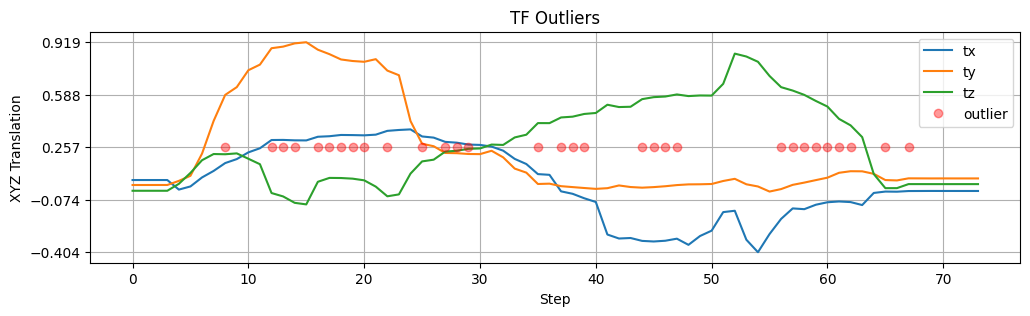

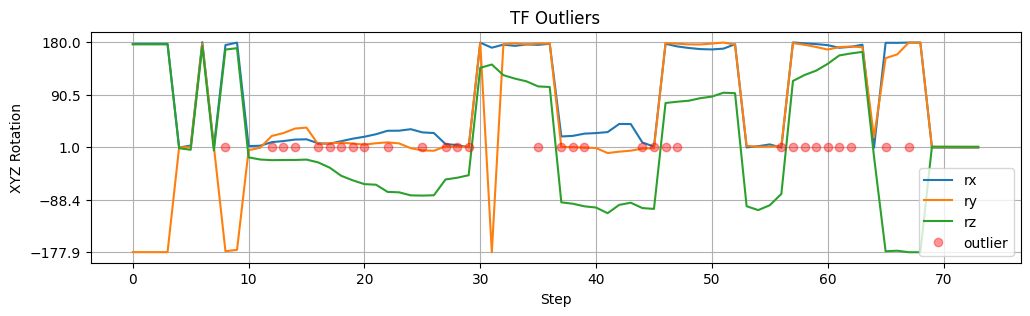

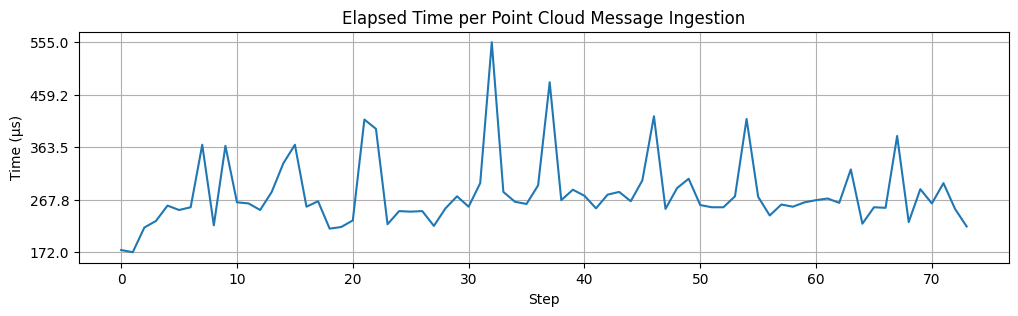

In [9]:
# Fetch XYZ translations
tx = columns['tx'].astype(float)
ty = columns['ty'].astype(float)
tz = columns['tz'].astype(float)
tmin, tmax = (np.min([tx.min(), ty.min(), tz.min()]), 
              np.max([tx.max(), ty.max(), tz.max()]))

rx = columns['rx'].astype(float)
ry = columns['ry'].astype(float)
rz = columns['rz'].astype(float)
rmin, rmax = (np.min([rx.min(), ry.min(), rz.min()]), 
              np.max([rx.max(), ry.max(), rz.max()]))

# Fetch outliers
outliers = columns['outlier'].astype('uint8')
outliers = np.argwhere(outliers == 1).flatten()

# Fetch time
elapsed = columns['elapsed'].astype(int)

print('Min/max translation:', '[', tmin, '..', tmax, ']')
print('Min/max rotation:', '[', rmin, '..', rmax, ']')
print('Number of outlier transforms:', outliers.size, f'({int(outliers.size/N_RECORDS * 100)}%)')
lineplot(N_RECORDS, tmin, tmax, [tx, ty, tz], "Step", "XYZ Translation", "TF Outliers", markers=outliers, labels=['tx', 'ty', 'tz', 'outlier'])
lineplot(N_RECORDS, rmin, rmax, [rx, ry, rz], "Step", "XYZ Rotation", "TF Outliers", markers=outliers, labels=['rx', 'ry', 'rz', 'outlier'])
lineplot(N_RECORDS, elapsed.min(), elapsed.max(), [elapsed], "Step", "Time (μs)", "Elapsed Time per Point Cloud Message Ingestion")

### 3.1. Filter Performance

In [10]:
non_outlier_idxs = np.argwhere(tfoutlier['data']['outlier'].astype(int) == 0)
tfoutlier_elapsed = tfoutlier['data']['elapsed'].astype(int)[non_outlier_idxs].T[0]
nan_elapsed = nan['data']['elapsed'].astype(int)
spatial_elapsed = spatial['data']['elapsed'].astype(int)
sor_elapsed = sor['data']['elapsed'].astype(int)

if (tfoutlier_elapsed.size != MIN_N_RECORDS or 
    nan_elapsed.size != MIN_N_RECORDS or 
    spatial_elapsed.size != MIN_N_RECORDS or 
    sor_elapsed.size != MIN_N_RECORDS):
    raise IndexError('The provided records or vectors have mismatching sizes!')

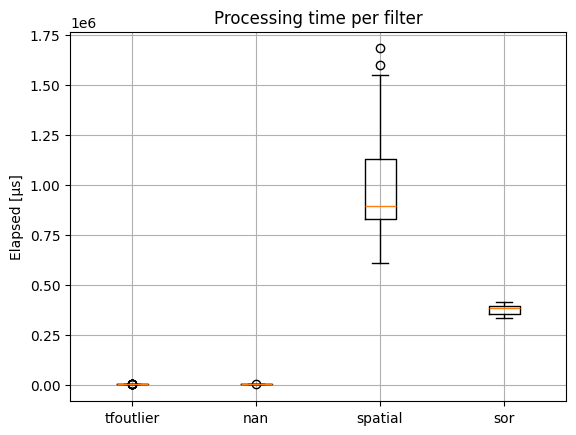

In [11]:
elapsed_time_filters = np.array([tfoutlier_elapsed, nan_elapsed, spatial_elapsed, sor_elapsed]).T
tags = ['tfoutlier', 'nan', 'spatial', 'sor']

boxplot(elapsed_time_filters, tags, 'Processing time per filter', notch=False, ylabel='Elapsed [μs]')

## 4. Visualization

In [12]:
cloud = o3d.io.read_point_cloud(PCL)
o3d.visualization.draw_geometries([cloud])

In [13]:
LH3_PCL = '../_artifacts/20250519-181945_accumulated_cloud/20250519-182156_accumulated_cloud_56mm_56587pts.pcd'

cloud = o3d.io.read_point_cloud(LH3_PCL)
o3d.visualization.draw_geometries([cloud])